In [85]:
import thinkplot
import thinkstats2
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import scipy.stats as ss
import math
import random

##Seaborn for fancy plots. 
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams["figure.figsize"] = (12,8)

# Estimation Applications

We can use our estimation skillz to do some more stuff beyond estimating the population. 

### But First, Estimate a Population

We can keep estimating populations with our analytical distribution. First - we'll do another normal one, but we'll grab some extra data to investigate it a bit more along the way. 

Our simulator will be like last time, it'll take in the emperical statistics from our sample, run a bunch of trials for generating analytical sample datasets, total those results up for analysis, and return it back. 
# 估计应用

除了估计人口之外，我们还可以使用我们的估算技能来做更多的事情。

### 但首先，估计一个人口

我们可以继续用我们的分析分布来估计人口。首先 - 我们会做另一个正常的，但我们会获取一些额外的数据来进一步调查它。

我们的模拟器将像上次一样，它将从我们的样本中获取经验统计数据，运行一系列试验以生成分析样本数据集，将这些结果汇总以进行分析，然后返回。

In [86]:
#Simulate Normal - from last time
#
#Add a return to send back the means and the predictions. 

#模拟正常 - 从上次
#
#添加返回以发回手段和预测。
#
def simulateNormal(mu=0, sigma=1, n=100, m=10000, ciLow=5, ciHi=95):
    means = [] #List of all the means that are created.#创建的所有手段的列表。 
    preds = []
    for j in range(m): #Run m number of simulations. #运行m次模拟。
        xs = np.random.normal(mu, sigma, n) #Generate a normal dist based on emperical data. #根据经验数据生成一个正常的dist。
        xbar = np.mean(xs) #Take the mean of the dist above's values#取上述dist的平均值
        means.append(xbar) #Add to list. 
        preds.append(xs) #predictions. 
    cdf = thinkstats2.Cdf(means) #Make a CDF of the means of the analytical dist's#制作分析分布的均值的CDF
    ci = cdf.Percentile(ciLow), cdf.Percentile(ciHi) #5th, 95th percentiles. 
    muList = [mu] * m
    stderr = mean_squared_error(means, muList, squared=False) #RMSE of how different the random analytical means are from the emp. mean. #RMSE 随机分析方法与 emp 的差异有多大。意思是。
    return cdf, ci, stderr, means, preds

We'll add these error calculators, we'll use them later. 
我们将添加这些误差计算器，稍后我们将使用它们。

In [87]:
def MeanError(estimates, actual):
    errors = [estimate-actual for estimate in estimates]
    return np.mean(errors)

In [88]:
def RMSE(estimates, actual):
    e2 = [(estimate-actual)**2 for estimate in estimates]
    mse = np.mean(e2)
    return np.sqrt(mse)

#### Load Some Data - Using LogNormal Data

Here we'll use some real data, data that has already been transformed to help us. The log.annual.inc value is the income <b><i>after</i></b> it has been transformed. This takes it from its original lognormal format to a normal distribution, which we know how to analyze easily. 

#### 加载一些数据 - 使用 LogNormal 数据

在这里，我们将使用一些真实数据，已经转换的数据来帮助我们。 log.annual.inc 值是 <b><i></i></b> 转换后的收入。这将其从其原始对数正态格式转换为正态分布，我们知道如何轻松分析。

In [89]:
#Load some data
df = pd.read_csv("data/loan_data.csv")
df.head()

,credit.policy,purpose,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
0,1,debt_consolidation,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,0,0,0
1,1,credit_card,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,0,0,0
2,1,debt_consolidation,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,0,0,0
3,1,debt_consolidation,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,0,0,0
4,1,credit_card,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,1,0,0


In [90]:
df.describe()

,credit.policy,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
count,9578.000000,9578.000000,9578.000000,9578.000000,9578.000000,9578.000000,9578.000000,9.578000e+03,9578.000000,9578.000000,9578.000000,9578.000000,9578.000000
mean,0.804970,0.122640,319.089413,10.932117,12.606679,710.846314,4560.767197,1.691396e+04,46.799236,1.577469,0.163708,0.062122,0.160054
std,0.396245,0.026847,207.071301,0.614813,6.883970,37.970537,2496.930377,3.375619e+04,29.014417,2.200245,0.546215,0.262126,0.366676
min,0.000000,0.060000,15.670000,7.547502,0.000000,612.000000,178.958333,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.103900,163.770000,10.558414,7.212500,682.000000,2820.000000,3.187000e+03,22.600000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.122100,268.950000,10.928884,12.665000,707.000000,4139.958333,8.596000e+03,46.300000,1.000000,0.000000,0.000000,0.000000
75%,1.000000,0.140700,432.762500,11.291293,17.950000,737.000000,5730.000000,1.824950e+04,70.900000,2.000000,0.000000,0.000000,0.000000
max,1.000000,0.216400,940.140000,14.528354,29.960000,827.000000,17639.958330,1.207359e+06,119.000000,33.000000,13.000000,5.000000,1.000000


<h3>Warmup - Estimate Normal Distribution for Income</h3>

We are given the log.annual.inc, which is the income of the applicants, run through a log transformation. Take a look via a graph...

We can also plot the de-logged, or exponential transformed, income, which should be our orignal incomes. We should double check to see if it makes sense, and to see what it looks like. 
<h3>预热 - 估计收入的正态分布</h3>

我们得到 log.annual.inc，它是申请人的收入，经过对数转换。通过图表来看看...

我们还可以绘制去日志或指数转换的收入，这应该是我们的原始收入。我们应该仔细检查它是否有意义，看看它是什么样子。

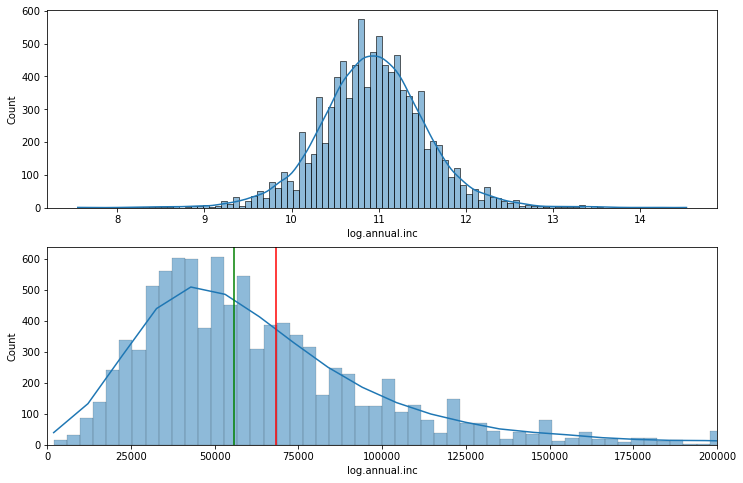

In [91]:
#Graph distribution of log income
thinkplot.PrePlot(2, 2, 1)
sns.histplot(df["log.annual.inc"], kde=True)
thinkplot.SubPlot(2)
sns.histplot(np.exp(df["log.annual.inc"]), kde=True).set(xlim=(0,200000))
plt.axvline(np.mean(np.exp(df["log.annual.inc"])), color="red")
plt.axvline(np.median(np.exp(df["log.annual.inc"])), color="green")
plt.ticklabel_format(style='plain', axis='x')
thinkplot.Config()

<h3>When lognormal is normal!</h3>

The log.annual.inc value looks really normal - estimate the income of the population as a whole. 

<b>Note:</b> this data is the income data, that has been transformed, with a log transformation. This is one example of some ways that we can use a transformation to make analysis easier. Transform the data into somehting that is easy to analyze, like a normal dist, do what you need to do, then transform in reverse to get raw data. 
<h3>当lognormal正常时！</h3>

log.annual.inc 值看起来很正常 - 估计整个人口的收入。

<b>注意：</b>此数据为收入数据，经过对数转换。这是我们可以使用转换使分析更容易的一些方法的一个示例。将数据转换成易于分析的东西，就像一个普通的 dist，做你需要做的，然后反向转换得到原始数据。

 The original distribution above could be analyzed directly via modelling it with a lognorm distribution, like we'll try below, but normal things are generally more simple, that's why this data was pretransformed. This is easier for lognorm stuff.  

#### Keep Working, Looking Backwards

Work with the data (already logged, the original format). First we'll do a little demonstration - the simulateNormal function also returns the "preds" value, which is the actual raw set of the predictions. This is the core of the estimations that we were doing before - we generate a bunch of "fake" distributions - each showing what we <b>expect</b> the distribution of the data to be like if it is actually following a normal distribution with the statistics (mean, standard deviation, and count) found in the emperical data. This plot draws each of those anticipated distributions at once, we can see that each one differs a little bit, but as more and more are drawn we can conclude a clear pattern. 

For the estimation before, we were taking the means of each of these distributions, and each of those is one prediction of the population mean. Our best estimate was the mean of those means. 

<b>Note:</b> play with the n and m values a little to draw different nubmers - the n value, or the sample size of the emperical data, will drastically impact the spread of the different sets of predictions. This should make sense - if we sample 10 people, their incomes may be distributed very randomly; if we sample 10,000 people, the true distribution of the data will outweigh those random low probability events. E.g. if you sample 10 Edmonton are residents for income, you might get 2 Oilers who make millions, which would make your income distribution look nothing like reality; this is unlikely, but definately possible. If you sample 10,000 people, maybe you still get 2 Oilers (the oilers are ~25 people out of ~1.3 million, so the odds of getting multiple of them is still extremely unlikely) but those 2 values will minorly impact 10,000 values while they will overwhelm 10 values. This is basically how sample size increases help with accuracy - though the differences are subtle, not massive differences with outliers, which may likely be filtered out anyway. 
上面的原始分布可以直接通过对数范数分布建模来分析，就像我们将在下面尝试的那样，但是正常的事情通常更简单，这就是为什么要对这些数据进行预转换。这对于 lognorm 的东西来说更容易。

####继续工作，向后看

使用数据（已记录，原始格式）。首先，我们将做一个小演示——simulateNormal 函数还返回“preds”值，这是预测的实际原始集。这是我们之前所做估计的核心——我们生成了一堆“假”分布——每一个都显示了我们<b>预期</b>如果数据实际上遵循正态分布的情况具有在经验数据中找到的统计量（平均值、标准差和计数）的分布。该图一次绘制了这些预期分布中的每一个，我们可以看到每一个都略有不同，但随着绘制的越来越多，我们可以得出一个清晰的模式。

对于之前的估计，我们采用了这些分布中的每一个的均值，其中每一个都是对总体均值的预测。我们最好的估计是这些手段的平均值。

<b>注意：</b> 稍微调整一下 n 和 m 值以绘制不同的数字 - n 值或经验数据的样本大小将极大地影响不同预测集的传播。这应该是有道理的——如果我们抽样 10 个人，他们的收入可能分布非常随机；如果我们对 10,000 人进行抽样，数据的真实分布将超过那些随机的低概率事件。例如。如果你抽取 10 个埃德蒙顿居民作为收入样本，你可能会得到 2 个年收入百万的油工，这会使你的收入分配看起来不像现实；这不太可能，但绝对有可能。如果您对 10,000 人进行抽样，也许您仍然会得到 2 个油工（油工大约有 130 万人中的 25 人，因此获得多个人的可能性仍然极小），但是这 2 个值会轻微影响 10,000 个值，而它们会压倒 10 个值。这基本上是样本量增加有助于提高准确性的方式——尽管差异是细微的，而不是与异常值的巨大差异，无论如何都可能会被过滤掉。

##### Alternate Outliering - the Median

If we do encounter something like outliers messing up our data, one thing to potentially try is to take the power of the median and the normal distribution into our hands. We'll use two facts:
<ul>
<li> The median is less impacted by outliers. 
<li> In a true normal distribution, the mean and median will be equal. 
</ul>

What's the end result - we can try replacing the mean with the median if outliers make an outsized concern. This is a bit of a hack, yes, but we are changing our approach to target our goal. We wish to estimate the mean income of the population as a whole - if we run into a scenario that using the emperical mean causes our analytical distributions to mirror the real distribution worse, we can make a judgement call to sawap it. Things such as this are not uncommon, we don't want to generate 100% accurate stats from the emperical data, though that may be nice, we want to use that emperical data as a tool to estimate - if we need to alter it, we can. We are basically making an assertion that the median will be a better estimator than the mean - or it will introduce less error. 
##### 备用异常值 - 中位数

如果我们确实遇到像异常值这样的东西弄乱了我们的数据，那么可能会尝试的一件事是将中位数和正态分布的力量掌握在我们手中。我们将使用两个事实：
<ul>
<li> 中位数受异常值的影响较小。
<li> 在真正的正态分布中，均值和中位数相等。
</ul>

最终结果是什么 - 如果异常值引起了极大的关注，我们可以尝试用中位数代替平均值。是的，这有点小题大做，但我们正在改变我们的方法来实现我们的目标。我们希望估计整个人口的平均收入——如果我们遇到使用经验平均值导致我们的分析分布更糟糕地反映真实分布的情况，我们可以做出判断来判断它。诸如此类的事情并不少见，我们不想从经验数据中生成 100% 准确的统计数据，尽管这可能很好，但我们希望使用该经验数据作为估计的工具——如果我们需要改变它，我们可以。我们基本上是在断言中位数将是比均值更好的估计量 - 或者它将引入更少的错误。

Mean: 10.932117137800155  Median: 10.92888357


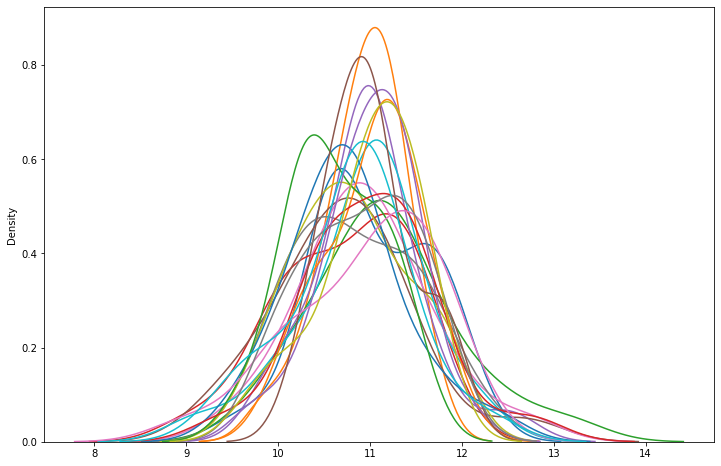

In [92]:
#Generate estimators for normal data. 
#为正常数据生成估计量。
mu = df["log.annual.inc"].mean()
sig = df["log.annual.inc"].std()
n = df["log.annual.inc"].count()
med = df["log.annual.inc"].median()
print("Mean:",mu," Median:",med)

#Run Estimations. 
#运行估计
cdf, ci, stderr, means, preds = simulateNormal(mu=med, sigma=sig, n=20, m=20, ciLow=5, ciHi=95)

#Graph each of those predictions from above - 1000 originally. 
#从上面绘制每个预测 - 最初是 1000。
for i in range(len(preds)):
    sns.kdeplot(preds[i])


In [93]:
print(preds)

[array([11.77169216, 10.68940032, 11.37410428, 10.46968828, 10.78773475,
       10.66638924, 10.54510618, 11.54973166, 10.77981813, 11.56892557,
       10.39261468, 10.60556564, 11.59938541,  9.64695754, 11.90475304,
       10.94369984, 10.87739539, 12.04056018, 10.45575918, 11.64349767]), array([10.9735839 , 11.25725923, 10.55998577, 11.01711611, 11.29753157,
       10.7088626 , 11.25048994, 11.23364206, 10.74166232, 11.02854518,
       11.59943729,  9.87665473, 10.38524401, 11.1791205 , 11.15370627,
       11.58764382, 10.88967613, 10.71805864, 10.30070847, 10.8888238 ]), array([11.39652299, 10.30455459, 12.18966872, 10.71240511, 11.229855  ,
       13.11726818, 12.3232521 , 11.62693173, 10.22965384, 10.91379981,
        9.77601864, 10.80449211, 11.6662063 , 11.47933566, 10.24403061,
       11.11519481, 11.14706819, 10.90345147, 11.03904761, 11.18073867]), array([11.23267993, 10.99550764, 11.10658711,  9.99620514, 11.44365399,
       10.37362672, 11.20675784, 10.53877203, 11.63107449

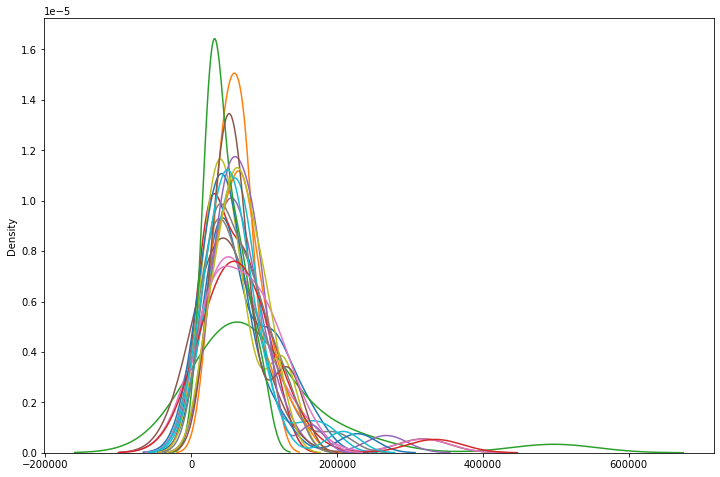

In [94]:
# With the log removed
for i in range(len(preds)):
    sns.kdeplot(np.exp(preds[i]))

##### What's This?

Each of those trial runs of the analytical distribution is slightly different, as we can see here. Each individual prediction varries, depending largely on:
<ul>
<li> The emperical sample size. 
<li> The closeness of the emperical/analytical distribution match. 
<li> The varriance in the data. 
</ul>

The better we get on those metrics, the less error there is in our projections, and the more accurately we can expect to estimate or predict. 

#### CDF of the Means

We are 90% confident that we are between the two CI limits. As a reminder, this CDF is made of the means of each of the distributions above - each line translates into one value, it's mean in the CDF data. 

##### 这是什么？

正如我们在这里看到的，分析分布的每一次试运行都略有不同。每个单独的预测都会有所不同，主要取决于：
<ul>
<li>经验样本量。
<li> 经验/分析分布匹配的紧密程度。
<li>数据的方差。
</ul>

我们在这些指标上获得的越好，我们的预测中的错误就越少，我们就越能准确地估计或预测。

#### 手段的 CDF

我们有 90% 的信心认为我们处于两个 CI 限制之间。提醒一下，这个 CDF 是由上述每个分布的平均值组成的——每一行都转换为一个值，它是 CDF 数据中的平均值。

(10.627951814718738, 11.021462273361346)

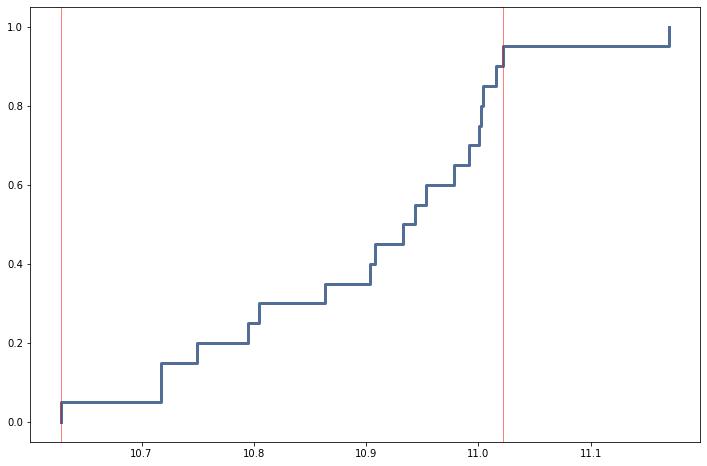

In [95]:
thinkplot.Cdf(cdf)
thinkplot.axvline(ci[0], color="red")
thinkplot.axvline(ci[1], color="red")
ci[0], ci[1]

#### Overall

Each random band up there is one prediction of the distribution of the population of income. I.E. each one is one execution of the "random" command that generates N variables according to the distribution. 

The means is taking the average of all of those above predicted distributions, then averaging them together. So that is estimating the mean of the population of income M times, graphed below.  

#### 全面的

每个随机波段都有一个对收入人口分布的预测。 IE。每一个都是“随机”命令的一次执行，该命令根据分布生成 N 个变量。

方法是取所有上述预测分布的平均值，然后将它们平均在一起。这就是估计收入人口 M 倍的平均值，如下图所示。

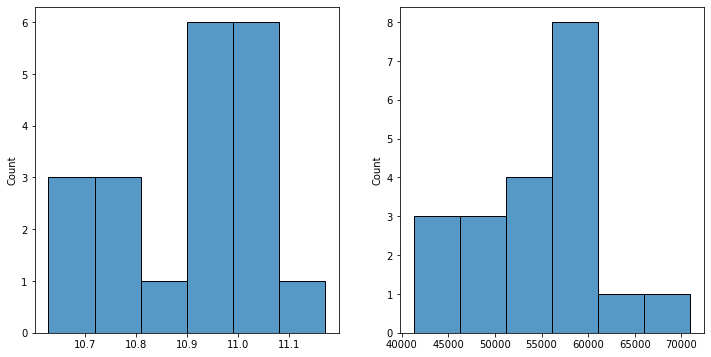

In [96]:
#Plot the means of the above distributions
#sns.kdeplot(means, linestyle="dotted")
thinkplot.PrePlot(2,1,2)
sns.histplot(means)
thinkplot.SubPlot(2)
sns.histplot(np.exp(means))
thinkplot.Config()

##### Show Real Data

We currently have a log transformed set of data. What if we want to see the real values along with our estimate. 
##### 显示真实数据

我们目前有一组对数转换的数据。如果我们想看到实际值和我们的估计值怎么办。

Estimated Population Mean: 54442.370057255364


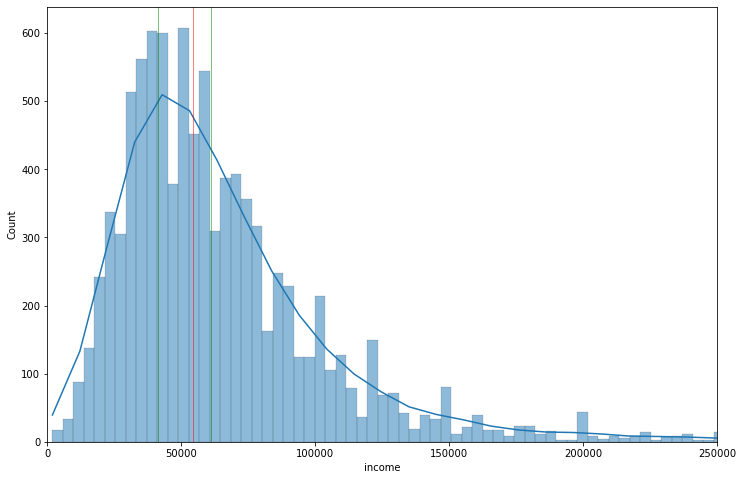

In [97]:
#Visualize as original data. Limit graph to $250k to make it look OK
df["income"] = np.exp(df["log.annual.inc"])
sns.histplot(df["income"], kde=True)
plt.xlim(0,250000)

convMed = np.exp(np.mean(means))
thinkplot.axvline(convMed, color="red")
thinkplot.axvline(np.exp(ci[0]), color="Green")
thinkplot.axvline(np.exp(ci[1]), color="Green")
print("Estimated Population Mean:", convMed) #,np.exp(ci[0]),np.exp(ci[1]))

## Discreet Distributions ## 谨慎分配

Until now, we've mainly dealt with distributions like the normal, lognormal, and exponential - distributions that are continuous, or they may take on any value. We also have distributions that measure discreet things - things which may only take on specific values. Two examples below are goals in sports (hockey, soccer, etc...) or votes in an election - each of these things are counted via whole numbers. 
到目前为止，我们主要处理的是正态分布、对数正态分布和指数分布——这些分布是连续的，或者它们可能具有任何值。我们也有一些分布来衡量谨慎的事物——可能只具有特定值的事物。下面的两个例子是运动中的目标（曲棍球、足球等）或选举中的投票——每一项都是通过整数计算的。

As we mentioned before, no matter the disribution we create, the process is pretty much the same. (I found this image online, and I think it is a good illustration. This is over-the-top detailed for us, it shows two standard deviations for normal on each side of the curve, but it does a reasonable job of illustrating what we need.)
正如我们之前提到的，无论我们创建什么分布，过程都几乎相同。 （我在网上找到了这张图片，我认为它是一个很好的插图。这对我们来说过于详细了，它显示了曲线每一侧的法线的两个标准偏差，但它在说明什么方面做得很合理我们需要。）


![Distributions](images/distributions.png "Distributions")

The mechanics of using these discreet distributions doesn't differ all that much from the continous ones. 
使用这些离散分布的机制与连续分布没有太大区别。

## Discreet Distributions in Practice

### Goals in a Game - Poisson

We can approximate the expected number of goals in a game by using a Poisson distribution. It is use to model things that happen periodically, but semi-randomly - like customrers walking into a store, phone calls to a call center, or goals in some game. 
## 实践中的谨慎分布

### 比赛中的进球 - 泊松

我们可以通过使用泊松分布来估计一场比赛中的预期进球数。它用于对周期性但半随机发生的事情进行建模——例如顾客走进商店、致电呼叫中心或某些游戏中的目标。

![Poisson](images/poisson.png "Poisson")

<br>
Below are a couple of examples - the input is the rate - in this case goals per game. It could be "calls per hour" or similar....
下面是几个例子 - 输入是速率 - 在这种情况下每场比赛的目标。它可能是“每小时通话”或类似的......

In [98]:
#Print a few
ss.poisson(5).rvs(5)

array([3, 4, 6, 8, 6])

<AxesSubplot:ylabel='Density'>

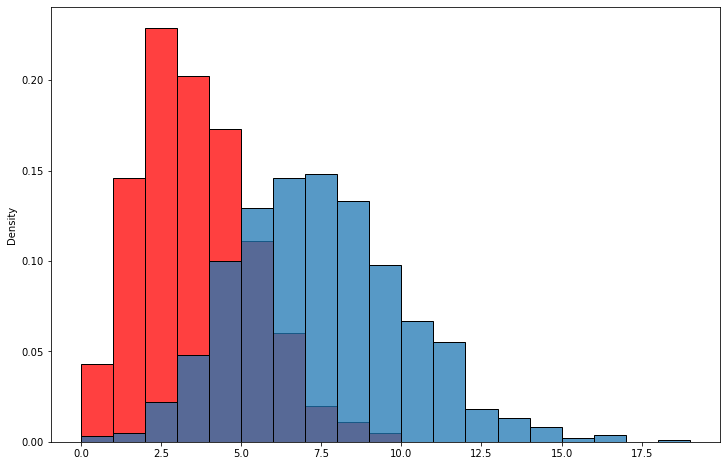

In [99]:
#Example poisson distributions
dist = ss.poisson(3)
dist2 = ss.poisson(7)

sns.histplot(dist.rvs(1000), binwidth=1, stat="density", color="red")
sns.histplot(dist2.rvs(1000), binwidth=1, stat="density")

<h2>Application - Forecast Games</h2><h2>应用程序 - 预测游戏</h2>

We can apply this to do a simple estimation of the Battle of Alberta. 
我们可以应用它来对阿尔伯塔战役进行简单的估计。
<h3>Load some data</h3>
<h3>加载一些数据</h3>

We can load some data on hockey! This came from hockey reference - it includes the goals per game for each time. Most goals wins, so we'll use that to create a model. 

<b>Note:</b> We are using a function to open Excel here, not a csv. Pandas probably has something to load whatever type of file you have, it just may require a different function or a different set of paramaters. 

我们可以加载曲棍球的一些数据！这来自曲棍球参考 - 它包括每次比赛的目标。大多数目标都会获胜，因此我们将使用它来创建模型。

<b>注意：</b> 我们在这里使用一个函数来打开 Excel，而不是 csv。 Pandas 可能有一些东西可以加载你拥有的任何类型的文件，它可能只需要不同的函数或一组不同的参数。

In [100]:
#Load and preview data
hock = pd.read_excel("data/sportsref_download.xlsx", sheet_name="Worksheet", engine="openpyxl", header=1)
hock.sample(10)

,Rk,Unnamed: 1,AvAge,GP,W,L,OL,PTS,PTS%,GF,...,PK%,SH,SHA,PIM/G,oPIM/G,S,S%,SA,SV%,SO
25,26.0,Ottawa Senators,26.2,6,2,4,0,4,0.333,15,...,77.78,0,0,11.5,11.5,180,8.3,192,0.901,0
8,9.0,New York Rangers,26.2,7,4,2,1,9,0.643,15,...,78.26,0,1,10.0,10.9,189,7.9,220,0.918,0
16,17.0,Tampa Bay Lightning,28.9,7,3,3,1,7,0.500,21,...,83.33,0,0,9.9,9.6,230,9.1,207,0.874,0
28,29.0,Los Angeles Kings,28.2,6,1,4,1,3,0.250,14,...,58.82,0,1,7.2,10.0,218,6.4,184,0.891,0
15,16.0,Winnipeg Jets,27.7,6,3,2,1,7,0.583,24,...,60.00,1,1,12.2,12.2,168,14.3,201,0.891,0
11,12.0,Pittsburgh Penguins,28.2,6,3,1,2,8,0.667,24,...,93.33,0,0,8.0,10.0,198,12.1,176,0.909,0
19,20.0,Dallas Stars,30.4,6,3,3,0,6,0.500,11,...,85.00,0,0,10.7,8.2,172,6.4,199,0.925,0
29,30.0,Montreal Canadiens,28.3,7,1,6,0,2,0.143,11,...,64.00,0,0,7.7,7.4,192,5.7,201,0.876,0
9,10.0,San Jose Sharks,28.6,6,4,2,0,8,0.667,20,...,85.71,1,1,8.0,10.0,166,12.0,168,0.917,1
20,21.0,New Jersey Devils,26.2,5,3,2,0,6,0.600,14,...,66.67,0,0,13.8,13.8,157,8.9,137,0.891,0


In [101]:
#Rename column for teams
hock = hock.rename(columns={'Unnamed: 1':"Team"})

In [102]:
#Find the GOALS PER GAME column - It will be very close to GF/G, but we need to be sure!!
hock.columns

Index(['Rk', 'Team', 'AvAge', 'GP', 'W', 'L', 'OL', 'PTS', 'PTS%', 'GF', 'GA',
       'SOW', 'SOL', 'SRS', 'SOS', 'GF/G', 'GA/G', 'PP', 'PPO', 'PP%', 'PPA',
       'PPOA', 'PK%', 'SH', 'SHA', 'PIM/G', 'oPIM/G', 'S', 'S%', 'SA', 'SV%',
       'SO'],
      dtype='object')

In [103]:
#Get Goals per game for the teams playing.
Oil = hock[hock["Team"]=="Edmonton Oilers"]
gfOil = Oil["GF/G"]
print("Oilers Goals per Game:", gfOil)
Fla = hock[hock["Team"]=="Calgary Flames"]
gfFla = Fla["GF/G"]
print("Falmes Goals per Game:", gfFla)

Oilers Goals per Game: 2    4.6
Name: GF/G, dtype: float64
Falmes Goals per Game: 7    3.5
Name: GF/G, dtype: float64


##### Simulate one Game
Simulate one game - take the goals per game, and generate one prediction of an outcome in terms of goals. 

##### 模拟一个游戏
模拟一场比赛 - 获取每场比赛的目标，并根据目标生成一个结果预测。

In [104]:
def SimGame(lam):
    dist = ss.poisson(lam)
    score = dist.rvs(1)
    return score[0]

In [105]:
SimGame(gfOil)

3

##### Simulate Many Games

Simulate a bunch of games, and check for bias in our estimator. 


##### 模拟许多游戏

模拟一堆游戏，并检查我们的估计器中的偏差。

In [106]:
def estimateGame(lam=2., m=1000):
    estimates = []
    for i in range(m):
        L = SimGame(lam)
        estimates.append(L)

    print('Goal Distribution:')
    print('rmse Goals:', RMSE(estimates, lam))
    print('mean error Goals:', MeanError(estimates, lam))
    
    pmf = thinkstats2.Pmf(estimates)
    thinkplot.Hist(pmf)
    thinkplot.Config(xlabel='Goals scored', ylabel='PMF')

Goal Distribution:
rmse Goals: 2.1441408535821522
mean error Goals: -0.007699999999999656


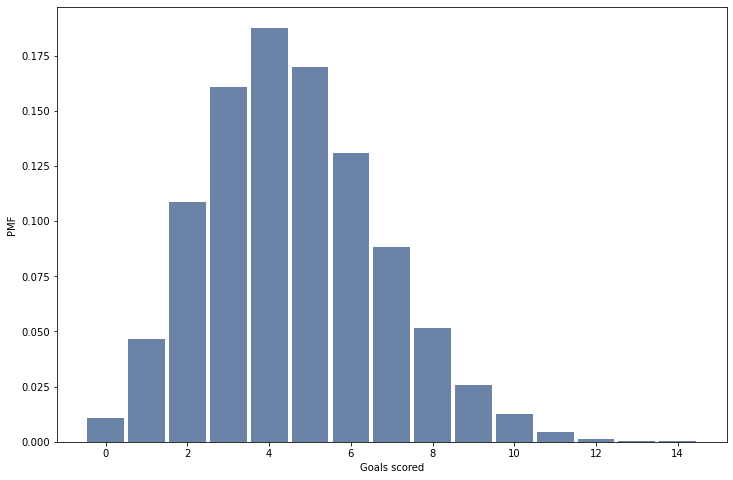

In [107]:
estimateGame(gfOil, 10000)

##### Create Winners

We can predict how many goals each team is to score in the simulated games, then see who scored the most. 

##### 创造赢家

我们可以预测每支球队在模拟比赛中的进球数，然后看看谁进球最多。

In [108]:
#Estimate a bunch of games, count how many one team wins vs the other. 
#估算一堆比赛，计算一支球队与另一支球队赢了多少场比赛。
def estimateMatch(team1=1, team2=1, m=1000):
    team1Wins = []
    ties = []
    for i in range(m):
        goal1 = SimGame(team1)
        goal2 = SimGame(team2)
        team1Wins.append(int(goal1>goal2))
        ties.append(int(goal1 == goal2))
    return team1Wins, ties

In [109]:
# Print results
oil_win, oil_ties = estimateMatch(gfOil,gfFla,1000)
np.mean(oil_win), np.mean(oil_ties)

(0.578, 0.139)

### Exercise - Try Some Other Teams!

<b>Note:</b> this model is a simplification of the real world, probably too much of one in this case. We can try a more realistic scenario by grabbing some odds from the upcomming week's NFL gambling lines, between the Baltimore Ravens and the Tampa Bay Bradys. 
### 练习 - 尝试其他一些团队！

<b>注意：</b>此模型是对现实世界的简化，在这种情况下可能过于简化。我们可以尝试一个更现实的场景，从即将到来的一周的 NFL 赌博线上，巴尔的摩乌鸦队和坦帕湾布雷迪斯队之间的比赛中获得一些赔率。

![lines](images/lines.png "Lines")

This means that the bookmakers have estimated two things:
<ul>
<li> Baltimore is expected to score 1.5 more points than the chump deflator Tom Brady. 
<li> The total number of points scored between the two teams is expected to be 45 points. 
</ul>

<b>What is the probability that Baltimore wins and destroys Brady's dreams like his marriage? </b>

这意味着博彩公司估计了两件事：
<ul>
<li> 巴尔的摩的得分预计将比笨蛋通货紧缩者汤姆布拉迪高出 1.5 分。
<li> 预计两队总得分为 45 分。
</ul>

<b>巴尔的摩赢得并摧毁布雷迪的梦想就像他的婚姻一样的概率是多少？ </b>

![Brady](images/brady.png "Brady")

##### Generate Expected Points 

We can transform, with a bit of algebra, the projected total and the spread (the +/-) part into an expectation for the number of points each team will score in this game. This expectation takes the place of the previous expectation - the average. 

##### 生成预期点

我们可以通过一些代数将预计的总数和分布（+/-）部分转换为每支球队在这场比赛中得分的期望值。这个期望取代了之前的期望——平均值。

In [110]:
#Get points per game for the teams playing.
total = 45
spreadB = -1.5
spreadT = 1.5

pointB = (total / 2) + (-spreadB /  2)
pointT = (total / 2) - (spreadT /  2)
pointB, pointT

(23.25, 21.75)

In [111]:
bWins, bTies = estimateMatch(pointB,pointT,1000)
np.mean(bWins), np.mean(bTies)

(0.58, 0.054)

##### How Could this Model be Better

Our point calculations are naive - we only based them on the raw expected total. For real odds, the bookmakers don't just consider a simple calculation of "how many points", they factor in different scenarios, matchups, injuries, weather, etc... to project who should win. In short, their internal models that are used to generate this are larger - involving more inputs, in an attempt to more thoroughly capture what impacts the outcome of a game. As well, these lines are not set to predict the exact outcome, they're set to balance betting. The bookies make money from the "vig" or basically a commission that is built into each bet; the -110 odds on each side of the "spread" bets show this - winning each pays back approximately 91% of the money, they pocket the rest. The actual lines also intend to balance the amount of money spent on each side of each bet, so they can max that vig without risking paying out massive losses. For many/most bets the true line is good, but sometimes popular teams have excessive betting, so games with the Lakers, Coyboys, and Yankees actually tend to get worse odds since their massive legion of fans will bet on them no matter what, and the bookie is incentivising bets on the other side to balance the interest. 
##### 这个模型怎么能更好

我们的积分计算是幼稚的——我们只基于原始的预期总数。对于真正的赔率，博彩公司不只是考虑“多少分”的简单计算，他们会考虑不同的情况、比赛、伤病、天气等……来预测谁应该赢。简而言之，他们用来生成这个的内部模型更大——涉及更多的输入，试图更彻底地捕捉影响游戏结果的因素。同样，这些线并不是用来预测确切的结果，而是用来平衡投注。博彩公司从“vig”中赚钱，或者基本上是每个赌注中内置的佣金； “点差”投注每边的 -110 赔率表明了这一点——每赢一盘，就可以返还大约 91% 的钱，其余的则入袋。实际线还打算平​​衡每个赌注的每一方所花费的金额，因此他们可以最大限度地提高赌注而不冒支付巨额损失的风险。对于许多/大多数赌注来说，真实的赌注是好的，但有时热门球队的赌注过多，因此与湖人队、小丑队和洋基队的比赛实际上往往会得到更差的赔率，因为无论如何他们的大量球迷都会在他们身上下注，并且博彩公司正在激励另一方的赌注以平衡利益。

## Polling - Celebrate the Downfall of Democracy! 

Suppose we are trying to estimate who would win the previous presidental election in the US - in Arizona. 

<b>Note:</b> Estimating the overall win would require projecting each state individually (and dealing with Nebraska and Maine), then projecting the total electoral college votes, since in a presidential election they are effectively separate elections. Same deal, more complex model. Canada is also more complex, since you'd need to project each house seat individually in 4ish way race, then project the distribution of seats, etc... same idea, way more complex scenario. In each of these scenarios winning the most votes doesn't translate into the overall win - winning the most votes, the most times, in multiple smaller elections translates into an overall win. 
## 投票 - 庆祝民主的垮台！

假设我们试图估计谁将赢得美国上届总统选举——在亚利桑那州。

<b>注意：</b> 估计总体胜利需要单独预测每个州（并与内布拉斯加州和缅因州打交道），然后预测选举团的总票数，因为在总统选举中它们实际上是单独的选举。同样的交易，更复杂的模型。加拿大也更复杂，因为您需要以 4 种方式分别预测每个房屋座位，然后预测座位分布等......同样的想法，更复杂的场景。在每一种情况下，赢得最多选票并不能转化为整体胜利——在多次较小的选举中赢得最多选票、最多次数会转化为整体胜利。

In real applications there's also an expectation of correlation between different elections - e.g. it is unlikely for the NDP to win all provincial ridings in west Edmonton, and lose all those in east Edmonton - there is some expected correlation that factors into overall predictions. Voter turnout also is factored in - lower turnouts tend to correspond to more conservative winners - hence the voter supression. There's also the expected sample bias, I'm an old millenial without a land line, and I don't know of any of my social circle who has ever been part of a political poll; the polling organizations know they aren't getting a perfectly representative samples so they build in corrections to their projections to correct for that. Actual polling organizations have factors like these, and others, built into their actual predictions, and this is an example of where their knowledge and skills differentiate their predictions. 

Having no idea how polls work has been one illustration of stats impacting the real world recently. Polls can of course "be wrong" and certain polling organizations generate biased projections, but much more often they are predicting things with a large amount of uncertainty and the less likely thing just happens. Even a poll that says something has an ~97% likelihood of happening is saying that the opposite will happen about one out of every 36 times - unlikely yes, but hardly a total shock - equivalent to rolling snake eyes (two dice, both ones) in a game of craps, which does happen, all the time, just ask Vegas. Legitimate polling organizations publish their confidence intervals and some sampling data at a minimum, and may share some of their interal modelling assumptions, though that is part of what makes them 'better' than their competitors, so they may not give it all. Check this document: [Polling Methodology](guides/polling_report.pdf) the Methodology section towards the end offers a good explaination of how they went about their work in executing the poll and processing the data. Media reports tend to be a very, very short summary of the real results - often to the point of removing needed context. 

在实际应用中，还期望不同选举之间存在相关性 - 例如新民主党不太可能赢得西埃德蒙顿的所有省级选区，而输掉东埃德蒙顿的所有省选 - 有一些预期的相关性会影响整体预测。选民投票率也被考虑在内 - 较低的投票率往往对应于更保守的获胜者 - 因此选民受到压制。还有预期的样本偏差，我是一个没有固定电话的老千禧一代，我不知道我的社交圈中有任何人曾经参与过政治投票；民意调查机构知道他们没有得到一个完全有代表性的样本，所以他们对他们的预测进行了修正以纠正这一点。实际的民意调查组织在他们的实际预测中内置了这些和其他因素，这是他们的知识和技能区分他们的预测的一个例子。

不知道民意调查如何运作是最近影响现实世界的统计数据的一个例证。民意调查当然可能是“错误的”，某些民意调查机构会产生有偏见的预测，但更多时候他们预测的事情有很大的不确定性，而不太可能发生的事情。即使是一项民意调查表明某事发生的可能性约为 97%，也表明相反的情况大约每 36 次就会发生一次——不太可能是，但几乎不是完全震惊——相当于滚动的蛇眼（两个骰子，两个骰子）在掷骰子游戏中，这确实发生，一直，只要问维加斯。合法的民意调查组织至少会公布他们的置信区间和一些抽样数据，并且可能会分享他们的一些内部建模假设，尽管这是让他们比竞争对手“更好”的部分原因，所以他们可能不会全力以赴。查看此文档：[投票方法](guides/polling_report.pdf) 最后的方法部分很好地解释了他们如何在执行投票和处理数据方面开展工作。媒体报道往往是对真实结果的非常非常简短的总结——通常到了删除所需背景的地步。

<b>What we have here is applicable for one specific election, such as an MP/Congressman race or a state-wide race like governor or elctoral college in the states. Full elections require the above complexity. </b>
<b>我们在此提供的内容适用于一项特定的选举，例如国会议员/国会议员竞选或各州的州长或选举学院等全州范围的竞选。完全选举需要上述复杂性。 </b>

### First - Establish probability an individual vote goes for Biden or Trump.

From 538: https://projects.fivethirtyeight.com/polls/president-general/arizona/ we can estimate basssed on all the previous polls that a person is approximately 49% likely to vote Biden, and 46% likely to vote Trump. 

Note: What 538 does to get these numbers involves some estimation already. They take multiple polls and attempt to combine them to make as accurate an estimate as possible. They try to correct for polling companies that historically skew Dem, or skew Rep, or tend to be more/less accurate. We could do this with one poll, it would be the same. 

Because we know (from experience) that only one of these two will actually win, we can try to isolate the share of votes of people who vote for one of these two - 3rd party votes are irrelevant. In reality, one of the things that pollsters will do is try to estimate the number of people who poll that they will vote 3rd party, then end up voting for Trump/Biden. This is an estimate they make based on past data, and domain knowledge. E.g. if we estimated that the share of 3rd party poll responses that voted T/B was skewed 2:1 towards Trump (e.g. libritarians voting Republican), we would add an adjustment here based on that knowledge. Maybe we'd add 1% to Biden's vote probability, and 2% to Trump's. This is something that really is an assumption though. These adjustments based on assumed human actions is what makes a really skilled pollster more accurate - they all know how to do the math. 
### 首先 - 确定个人投票支持拜登或特朗普的概率。

来自 538：https://projects.fivethirtyeight.com/polls/president-general/arizona/ 我们可以根据之前的所有民意调查估计，一个人投票拜登的可能性约为 49%，投票特朗普的可能性约为 46%。

注意：538 为获得这些数字所做的工作已经涉及一些估计。他们进行多次民意调查并尝试将它们结合起来以做出尽可能准确的估计。他们试图纠正那些在历史上歪曲 Dem 或歪曲 Rep 或倾向于或多或少准确的民意调查公司。我们可以通过一项民意调查来做到这一点，它是一样的。

因为我们（根据经验）知道这两个中只有一个会真正获胜，所以我们可以尝试隔离投票给这两个之一的人的选票份额——第三党的选票是无关紧要的。实际上，民意调查人员会做的一件事是试图估计有多少人会投票给第三党，然后最终投票给特朗普/拜登。这是他们根据过去的数据和领域知识做出的估计。例如。如果我们估计投票 T/B 的第 3 党民意调查回复的份额向特朗普倾斜 2:1（例如，自由主义者投票共和党），我们将根据该知识在此处添加调整。也许我们会给拜登的投票概率增加 1%，给特朗普的投票概率增加 2%。不过，这确实是一个假设。这些基于假设的人类行为的调整使真正熟练的民意测验者更加准确 - 他们都知道如何进行数学计算。

In [112]:
#How likely is it for someone to vote Trump and Biden?
probT = .46/(.49+.46)
print("Trump Prob:", probT)

probB = .49/(.49+.46)
print("Biden Prob:", probB)

Trump Prob: 0.48421052631578954
Biden Prob: 0.5157894736842106


So, of the votes that will matter, about 51.5% go Biden, 48.5% go Trump. How does this translate to a person making a vote. For each person, we can make a function to basically get one response. 

This person will return one vote. It will be either a vote for Trump or for Biden. That decision will be random, but it will be set with a likelihood that we calculated before - apx 51.5% of the total voters will vote Biden, as the number of votes we collect gets large. 

Note: for the example, we'll use a vote for Biden to be True/1. A vote for Trump is False/0. This is arbitrary. 

Below we have a function to generate a prediciton using a BINOMIAL distribution - it is either 1 or 0. (A 1 sample binomial dist is also called a Bernouli)
因此，在重要的选票中，约 51.5% 的选票投给了拜登，48.5% 的选票投给了特朗普。这如何转化为一个人进行投票。对于每个人，我们可以做一个函数，基本上得到一个响应。

此人将返回一票。这将是对特朗普或拜登的投票。该决定将是随机的，但将根据我们之前计算的可能性进行设定——随着我们收集的选票数量越来越多，大约 51.5% 的选民将投票给拜登。

注意：对于示例，我们将使用对拜登的投票结果为 True/1。对特朗普的投票是 False/0。这是任意的。

下面我们有一个使用 BINOMIAL 分布生成预测的函数 - 它是 1 或 0。（1 个样本二项式分布也称为伯努利）

In [113]:
#Generate one vote, with a likelihood supplied as an argument. 
#生成一票，将可能性作为参数提供。
def oneVote(probCalc):
    vote = np.random.binomial(n=1, p=probCalc)
    return vote

In [114]:
#Get one vote, is it Biden or not?
#Run the cell a bunch of times to repeat. 
oneVote(probB)

1

OK, now we have our fake voter. One vote isn't good enough, we need to sample a bunch of people. 
Below, generate a list of n predicted voters. Then check the number that voted Biden. 

好的，现在我们有了我们的假选民。 一张票不够好，我们需要对一群人进行抽样。
下面，生成一个包含 n 个预测选民的列表。 然后检查投票拜登的人数。

In [115]:
#Get an arbitrary number of simulated votes
#获得任意数量的模拟投票
def getSample(voteProb, n=1000):
    vote_list = []
    for i in range(n):
        vote_list.append(oneVote(voteProb))
    return vote_list

In [116]:
#Get a bunch of votes, print the percentage that are Biden. 
#Try changing n and see what happens. 
#获得一堆选票，打印拜登的百分比。
#尝试改变n，看看会发生什么。
tmp = getSample(probB, 5000)
np.mean(tmp)

0.5268

#### Do Some Simulating

That allows us to make one simulation. Congrats - that thing above is one simulated election. We should take a bunch though, and average their results together. 
We can also plot some examples to see what a difference the sample size makes. 

#### 做一些模拟
这使我们能够进行一次模拟。 恭喜 - 上面的内容是一次模拟选举。 我们应该拿一堆，把他们的结果平均起来。
我们还可以绘制一些例子来看看样本量有什么不同。

In [117]:
def getSamples(voteProb, n=1000, samples=100, ciLow=2.5, ciHi=97.5):
    meanList = []
    for i in range(samples):
        meanList.append(np.mean(getSample(voteProb, n)))
    muList = [voteProb] * samples
    cdf = thinkstats2.Cdf(meanList) #Make a CDF of the means of the analytical dist's
    ci = cdf.Percentile(ciLow), cdf.Percentile(ciHi) #5th, 95th percentiles. 
    stderr = mean_squared_error(meanList, muList, squared=False)
    return meanList, stderr, cdf, ci

In [118]:
getSamples(probB, 1000, 5)

([0.507, 0.549, 0.519, 0.542, 0.506],
 0.019866186699042644,
 Cdf([0.506 0.507 0.519 0.542 0.549], [0.2 0.4 0.6 0.8 1. ]),
 (0.506, 0.549))

##### Sample Size Check
Obviously, the more people we've surveyed, the more we should be able to trus our projections, or in other words, the larger our sample size is, the less our projection should waiver. 

All of these graphs have a fixed x-axis, the "tigher" the projections (probability of a Biden win) are, the more confident we are in that prediction. Or, the more likely "that thing" is to happen, and the less likely some "far away thing" is to happen. 

##### 样本量检查
显然，我们调查的人越多，我们就越应该能够相信我们的预测，或者换句话说，我们的样本量越大，我们的预测应该放弃的越少。

所有这些图表都有一个固定的 x 轴，预测（拜登获胜的概率）越“紧密”，我们对该预测的信心就越大。 或者，“那件事”发生的可能性越大，“遥远的事情”发生的可能性就越小。

Error: 0.1504618927284743
Error: 0.05328564638627671
Error: 0.015774600012049955
Error: 0.005283972315872127
Error: 0.00158103339395402


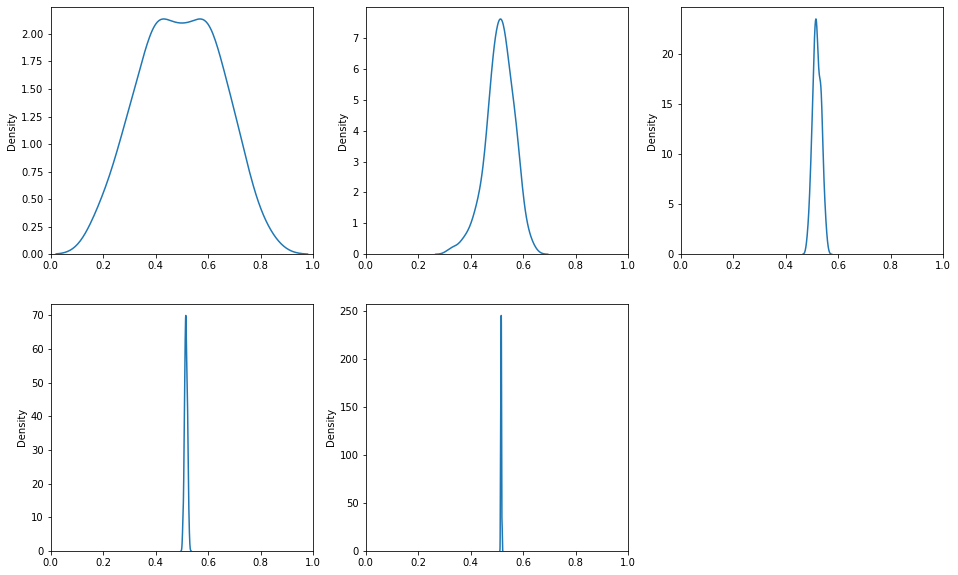

In [119]:
#Print a grid of differnet n values

countHist = 5
nVals = [10,100,1000,10000,100000,1000000]
thinkplot.PrePlot(6,rows=2,cols=3)
samples = 100

for i in range(countHist):
    tmpH, err, cdf, ci = getSamples(probB, nVals[i], samples)
    thinkplot.SubPlot(i+1)
    sns.kdeplot(tmpH).set(xlim=(0,1))
    print("Error:", err)
thinkplot.Config()

Error: 0.16013757935390943
Error: 0.05090953902202319
Error: 0.01566093380502675
Error: 0.005055534253943668
Error: 0.0016235588956162402


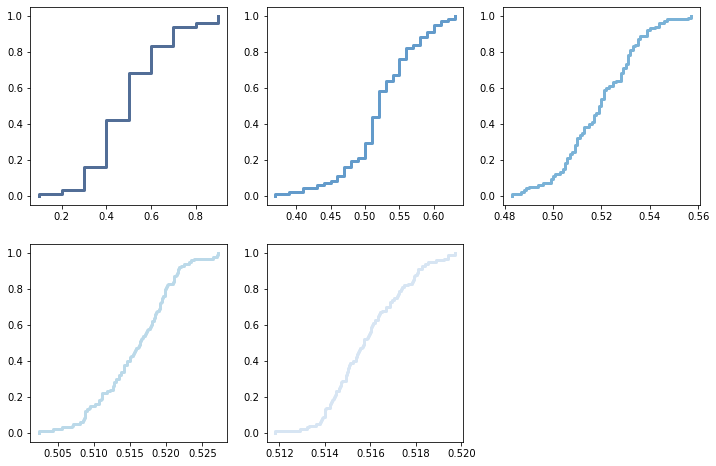

In [120]:
#And the CDFs
from matplotlib.pyplot import xlim


for i in range(countHist):
    tmpH, err, cdf, ci = getSamples(probB, nVals[i], samples)
    thinkplot.SubPlot(i+1)
    thinkplot.Cdf(cdf)
    print("Error:", err)
thinkplot.Config()

Above are multiple executions, with multiple n values. What we should see is that as we get larger and larger n values - the number of 'surveys' taken, we should get closer and closer to a normal curve centered around the expected percentage of votes for Biden = 51.5%. 上面是多次执行，有多个 n 值。 我们应该看到的是，随着我们获得越来越大的 n 值 - 进行的“调查”数量，我们应该越来越接近以拜登的预期投票百分比 = 51.5% 为中心的正常曲线。

### Predict the Winner!!!!

Now we can calculate our projections!

We don't really want to know what percentage of votes Biden is going to get, we want to know how likely he is to win. What we can do below is run some simulations, and for each one see if Biden wins, or if he looses, and then count them up. In each simulation, one candidate will get the most votes, and be declared the winner. 

The three lines below show us the scenarios at each end of the error - the worst and best case expected scenarios. 
### 预测获胜者！！！！

现在我们可以计算我们的预测了！

我们真的不想知道拜登将获得多少选票，我们想知道他获胜的可能性有多大。 下面我们可以做的是运行一些模拟，每一个都看看拜登是赢了还是输了，然后把它们算出来。 在每次模拟中，一名候选人将获得最多的选票，并被宣布为获胜者。

下面的三行向我们展示了错误每一端的情景——最坏和最好的预期情景。

0.787


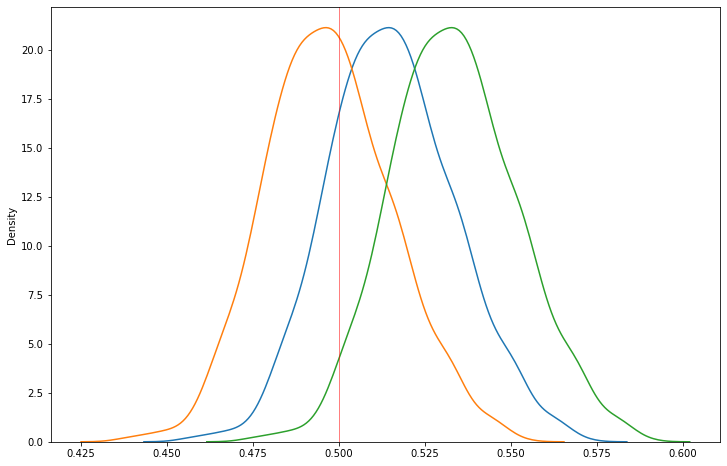

In [121]:
#Run a bunch of trials and count how many Biden wins in. 
trials = 1000
means, err, cdfFin, ciFin = getSamples(probB, n=700, samples=trials)
lowest = means - err
highest = means + err
bWins = 0 
for i in range(len(means)):
    if means[i] > .5000:
        bWins = bWins + 1
print(bWins/trials)

sns.kdeplot(means)
sns.kdeplot(lowest)
sns.kdeplot(highest)
thinkplot.axvline(.5, color="red")

### Final Projection of Winner

Fraction of Scenarios where Biden wins is 78.7% 
We are 95 percent confident that Biden will get between 48.1% and 55.3% percent of the vote


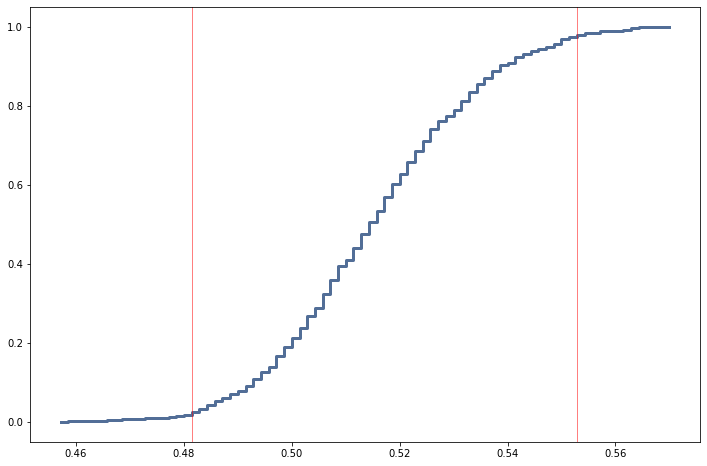

In [122]:
thinkplot.Cdf(cdfFin)
thinkplot.axvline(ciFin[0], color="red")
thinkplot.axvline(ciFin[1], color="red")
print("Fraction of Scenarios where Biden wins is %.1f%% " % ((1-cdfFin.Prob(.50))*100))#拜登获胜的场景比例是
print("We are 95 percent confident that Biden will get between %.1f%% and %.1f%% percent of the vote" % (ciFin[0]*100, ciFin[1]*100))

##### Results＃＃＃＃＃ 结果

So, roughly a 4/5 chance Biden wins. The alternative is much less likely, but still very possible. 
114 / 5,000
因此，拜登获胜的机会大约为 4/5。 替代方案的可能性要小得多，但仍然很有可能。
![Biden](images/biden.jpeg "Biden")

## Exercise - Election

There's going to be an election for the president of your class. There are 3 candidates, and the latest pre-election polling results by the school newspaper were:
<ul>
<li> Tricky Nicky - 38 votes
<li> Crazy Jimmy - 34 votes
<li> Silly Willie - 1 vote
</ul>

You feel that the polls are plausible, based on your subjective judgement of the feelings before the election. You want to embarrass those school newspaper nerds and make a more accurate prediction. <b>What is the probability of each candidate winning the election? And what is the 90% CI of Jimmy winning?</b>

你们班的校长要选举了。 有3名候选人，校报最新的选举前投票结果为：
<ul>
<li> Tricky Nicky - 38 票
<li> 疯狂的吉米 - 34 票
<li> 傻威利 - 1 票
</ul>

你觉得民意调查是可信的，基于你对选举前感受的主观判断。 你想让那些校报书呆子难堪，并做出更准确的预测。 <b>每位候选人获胜的概率是多少？ Jimmy 获胜的 90% CI 是多少？</b>

In [123]:
tn_c = 38
cj_c = 34
sw_c = 1
total_relevant_c = tn_c + cj_c

pN = tn_c/total_relevant_c
pJ = cj_c/total_relevant_c
pN,pJ

(0.5277777777777778, 0.4722222222222222)

<b>I will label Jimmy winning as 1. So this is a calculation of the probability that Jimmy wins.<b>
<b>我将吉米获胜标记为 1。所以这是对吉米获胜概率的计算。<b>


0.266


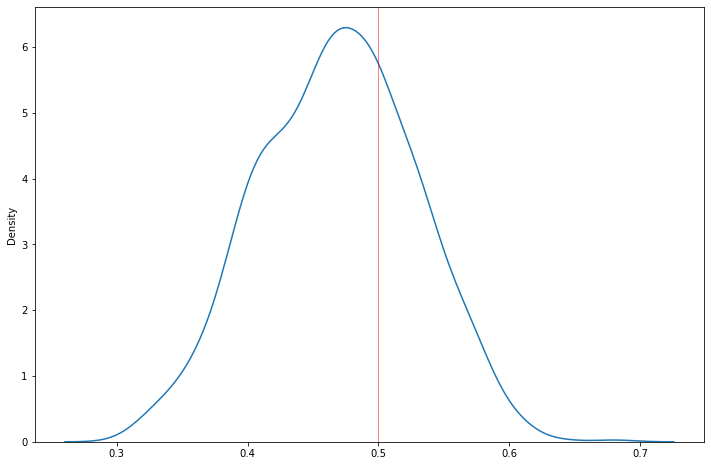

In [124]:
#Run a bunch of trials and count how many Biden wins in. #运行一堆试验并计算拜登获胜的次数。
trials2 = 1000
means2, err2, cdfFin2, ciFin2 = getSamples(pJ, n=total_relevant_c, samples=trials, ciLow=5, ciHi=95)

jWins = 0 
for i in range(len(means2)):
    if means2[i] > .5000:
        jWins = jWins + 1
print(jWins/trials2)

sns.kdeplot(means2)
thinkplot.axvline(.5, color="red")

#### CDF For Win Totals

Fraction of Scenarios where Jimmy wins is 26.6% 
We are 90 percent confident that Jimmy will get between 37.5% and 56.9% percent of the vote


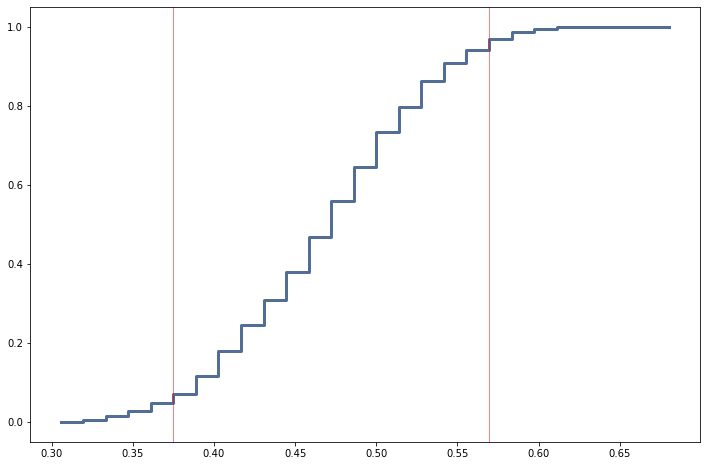

In [125]:
thinkplot.Cdf(cdfFin2)
thinkplot.axvline(ciFin2[0], color="red")
thinkplot.axvline(ciFin2[1], color="red")
print("Fraction of Scenarios where Jimmy wins is %.1f%% " % ((1-cdfFin2.Prob(.50))*100))
print("We are 90 percent confident that Jimmy will get between %.1f%% and %.1f%% percent of the vote" % (ciFin2[0]*100, ciFin2[1]*100))